In [23]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [24]:
import pandas as pd
import numpy as np


def filter_academic_year(df, year):
    """Filter dataframe by academic year and drop Year column"""
    filtered_df = df[df["AcademicYear"] == year].copy()
    return filtered_df.drop(columns=["Year"])


def standardize_acgr_columns(acgr_df, mapping):
    """Rename ACGR columns to match Census Day naming convention"""
    renamed_df = acgr_df.copy()
    new_columns = {}

    for col in acgr_df.columns:
        parts = col.split(".")
        if len(parts) == 2 and parts[1] in mapping:
            new_col = f"{parts[0]}.{mapping[parts[1]]}"
            new_columns[col] = new_col

    return renamed_df.rename(columns=new_columns)


acgr_to_census_mapping = {
    # Race/Ethnicity
    "RB": "RE_B",  # African American
    "RI": "RE_I",  # American Indian or Alaska Native
    "RA": "RE_A",  # Asian
    "RF": "RE_F",  # Filipino
    "RH": "RE_H",  # Hispanic or Latino
    "RD": "RE_D",  # Not Reported
    "RP": "RE_P",  # Pacific Islander
    "RT": "RE_T",  # Two or More Races
    "RW": "RE_W",  # White
    # Gender
    "GM": "GN_M",  # Male
    "GF": "GN_F",  # Female
    "GX": "GN_X",  # Non-Binary
    "GZ": "GN_Z",  # Missing Gender
    # Student Groups
    "SE": "SG_EL",  # English Learners
    "SD": "SG_DS",  # Students with Disabilities
    "SS": "SG_SD",  # Socioeconomically Disadvantaged
    "SM": "SG_MG",  # Migrant
    "SF": "SG_FS",  # Foster
    "SH": "SG_HM",  # Homeless
    # Total
    "TA": "TA",  # Total
}

In [25]:
census_day = pd.read_sql_query("SELECT * FROM CensusDayWide", con)
acgr = pd.read_sql_query("SELECT * FROM ACGRWide", con)

acgr_standardized = standardize_acgr_columns(acgr, acgr_to_census_mapping)

acgr_standardized = acgr_standardized[
    acgr_standardized["Year"].isin(census_day["AcademicYear"].unique())
]

merged = pd.merge(
    census_day,
    acgr_standardized,
    left_on=[
        "AggregateLevel",
        "CountyCode",
        "DistrictCode",
        "SchoolCode",
        "AcademicYear",
    ],
    right_on=["AggregateLevel", "CountyCode", "DistrictCode", "SchoolCode", "Year"],
    how="outer",
    indicator=True,
)

for col in merged.columns:
    if any(substr in col for substr in ["Rate", "Percent", "ENR", "GR_"]):
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

academic_years = [
    "2017-18",
    "2018-19",
    "2019-20",
    "2020-21",
    "2021-22",
    "2022-23",
    "2023-24",
]

grad_rate_columns_to_drop = [
    col
    for col in merged.columns
    if col.startswith("RegHSDiploma")
    or col.startswith("Dropout")
    or col.startswith("UniReqs")
]
csu_rate_columns_to_drop = [
    col
    for col in merged.columns
    if col.startswith("UniReqs") or col.startswith("RegHSDiploma")
]

year_df_mapping = {year: filter_academic_year(merged, year) for year in academic_years}

# XGBoost


### Cross Validated Grad Rate


In [26]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance
from modeling.utils.xgboost import (
    plot_top_k_features,
    plot_feature_avg_variance,
    plot_feature_time_series,
)

cv_xgb_models = {}

target_column = "RegHSDiplomaRate.TA"

for year, year_df in year_df_mapping.items():

    cv_result = cross_validate_xgboost(
        df=year_df,
        target_column=target_column,
        columns_to_drop=[target_column, "AcademicYear"] + grad_rate_columns_to_drop,
        n_splits=5,
        print_results=False,
    )

    cv_xgb_models[year] = cv_result

<Figure size 1400x600 with 0 Axes>

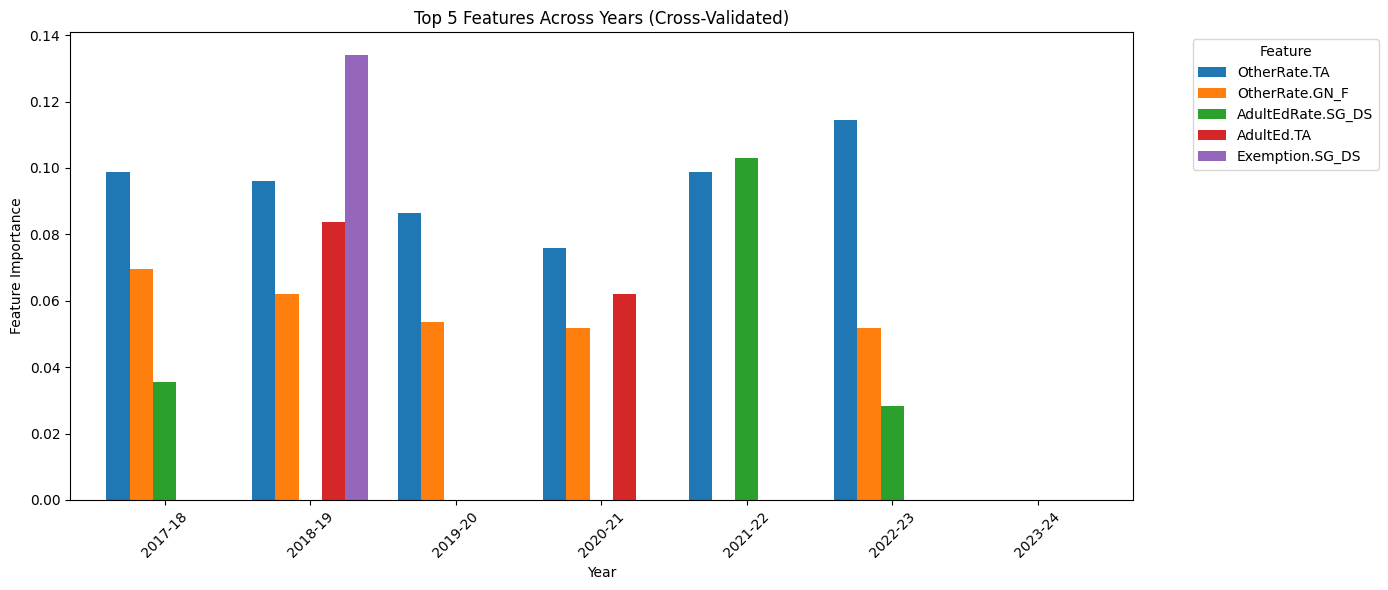

<Figure size 1400x600 with 0 Axes>

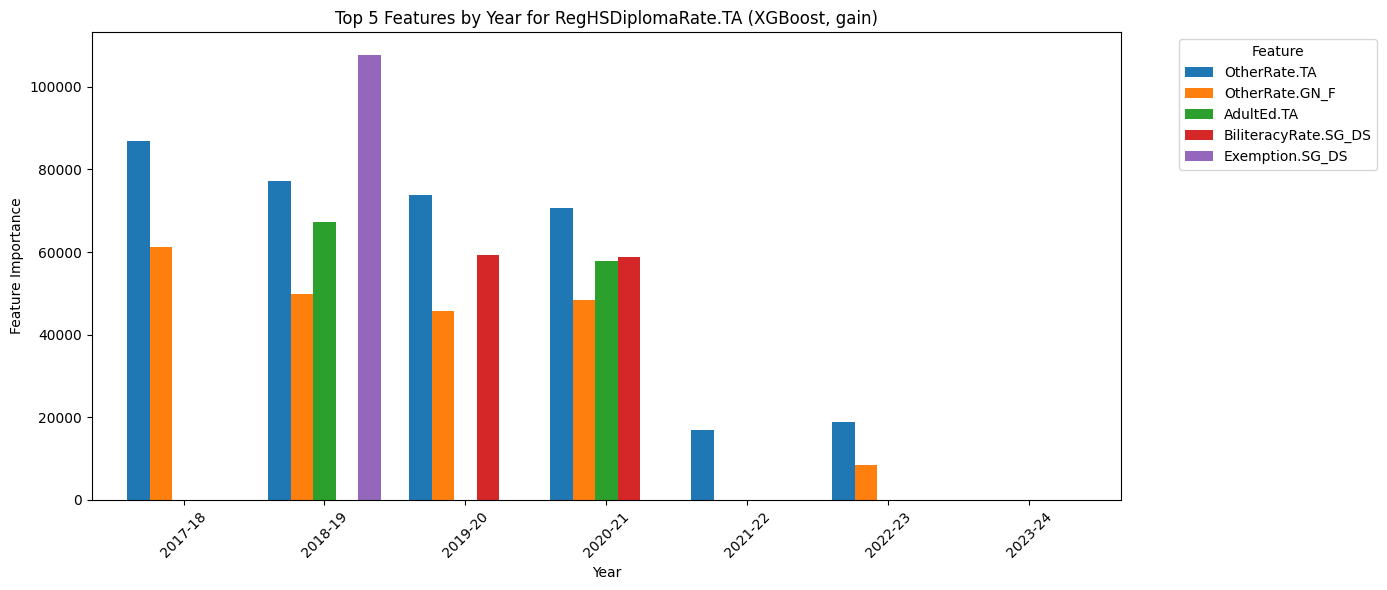

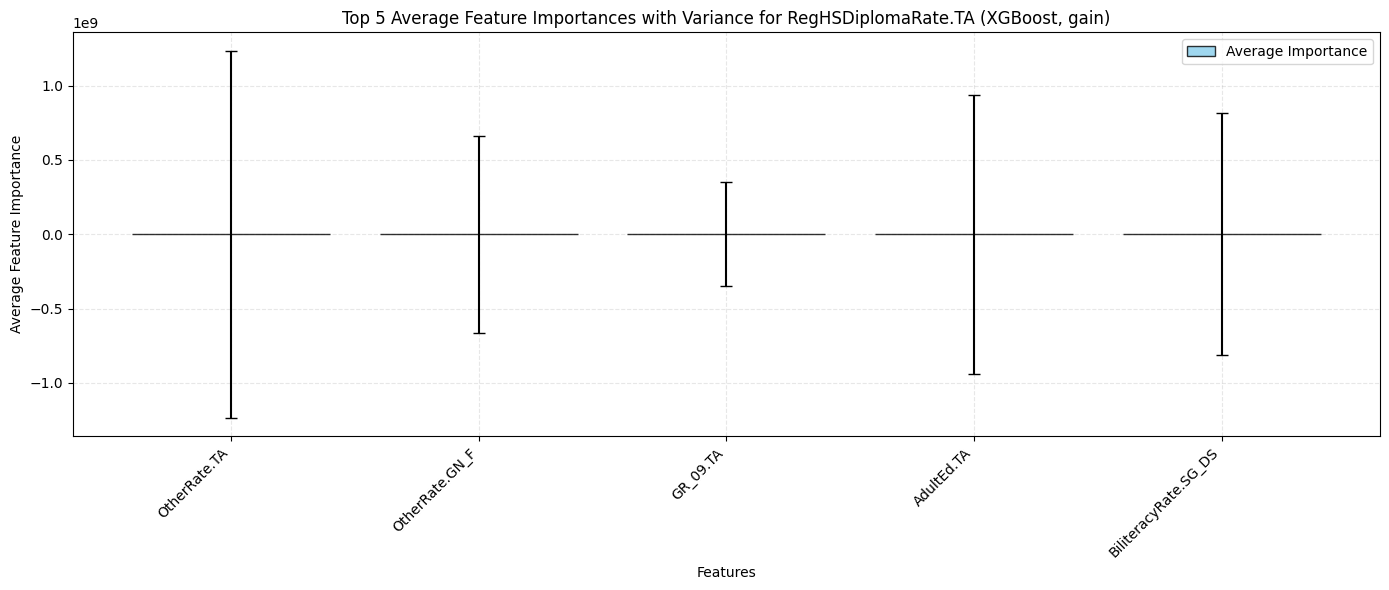

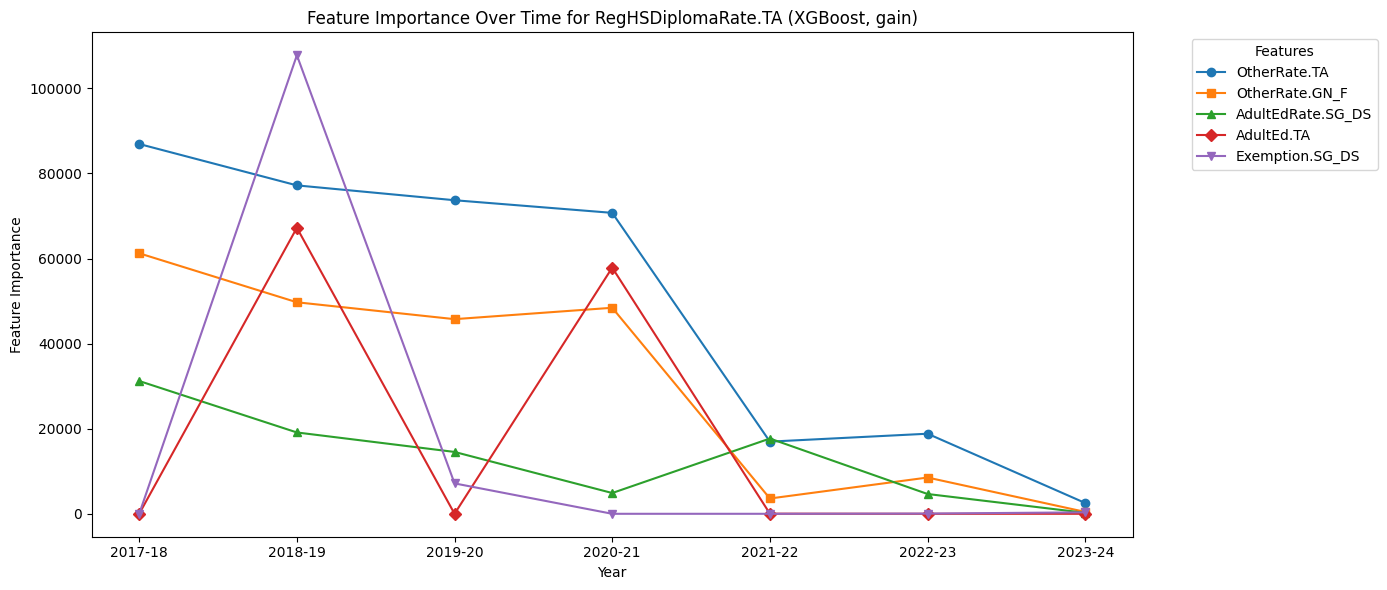

In [27]:
top_features = plot_cv_feature_importance(cv_xgb_models, top_n=5)
plot_top_k_features(cv_xgb_models, "XGBoost", "gain", target_column, k=5)
plot_feature_avg_variance(cv_xgb_models, "XGBoost", "gain", target_column)
plot_feature_time_series(
    cv_xgb_models, "XGBoost", "gain", target_column, top_features[:5]
)

### Cross Validated CSU/UC Readiness Rate


In [28]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance
from modeling.utils.xgboost import (
    plot_top_k_features,
    plot_feature_avg_variance,
    plot_feature_time_series,
)

cv_xgb_models = {}

target_column = "UniReqsPercent.TA"

for year, year_df in year_df_mapping.items():

    cv_result = cross_validate_xgboost(
        df=year_df,
        target_column=target_column,
        columns_to_drop=[target_column, "AcademicYear"] + csu_rate_columns_to_drop,
        n_splits=5,
        print_results=False,
    )

    cv_xgb_models[year] = cv_result

<Figure size 1400x600 with 0 Axes>

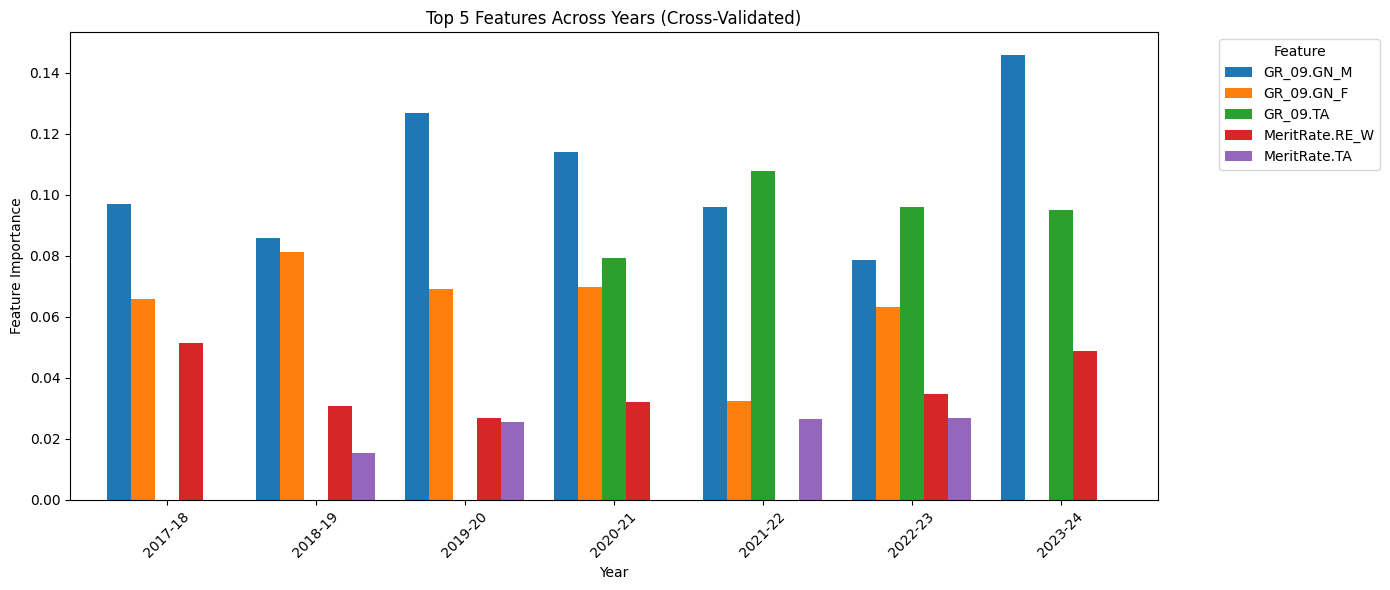

<Figure size 1400x600 with 0 Axes>

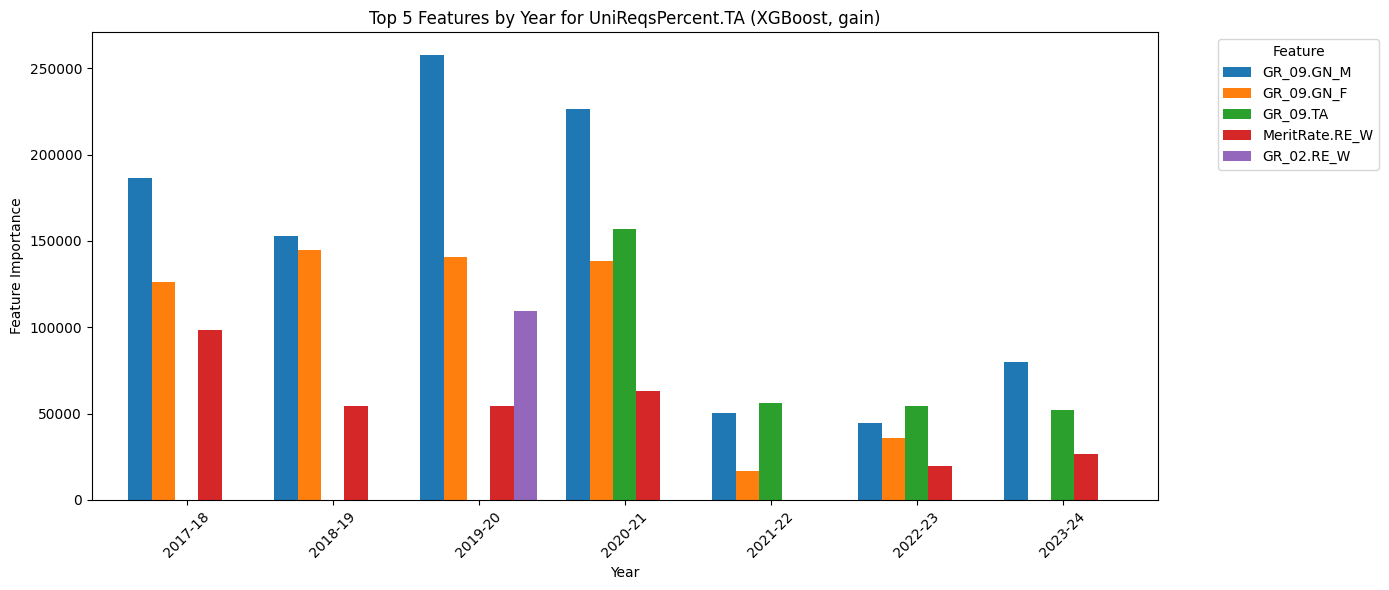

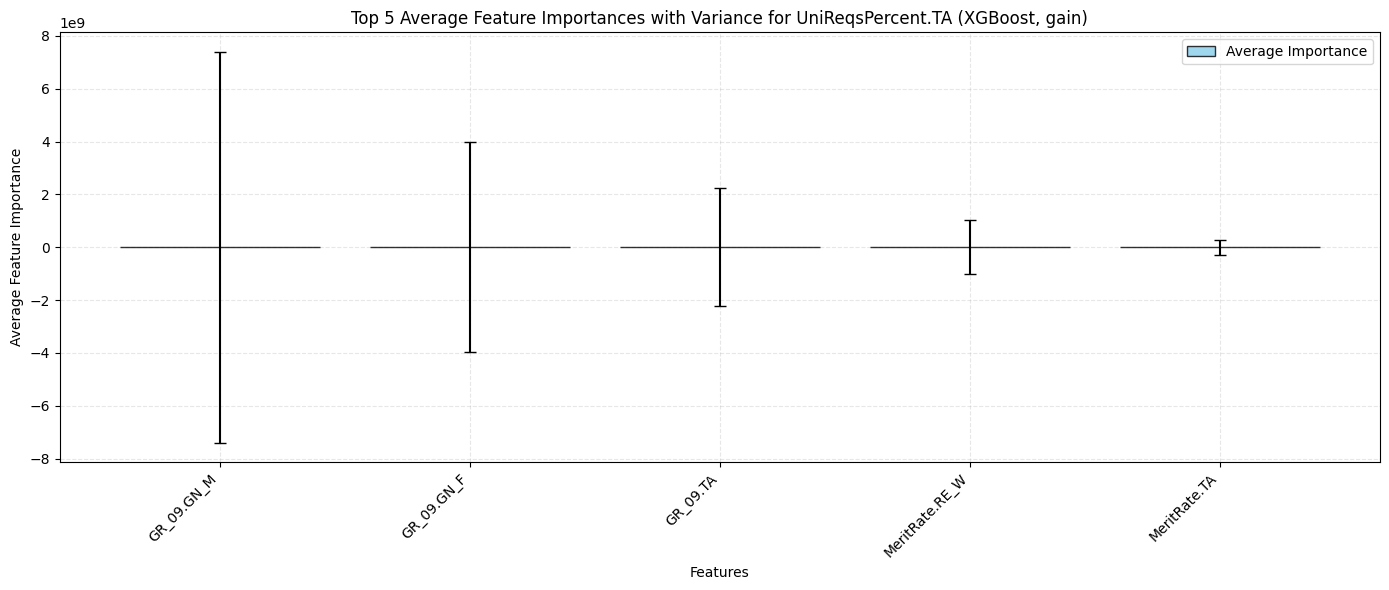

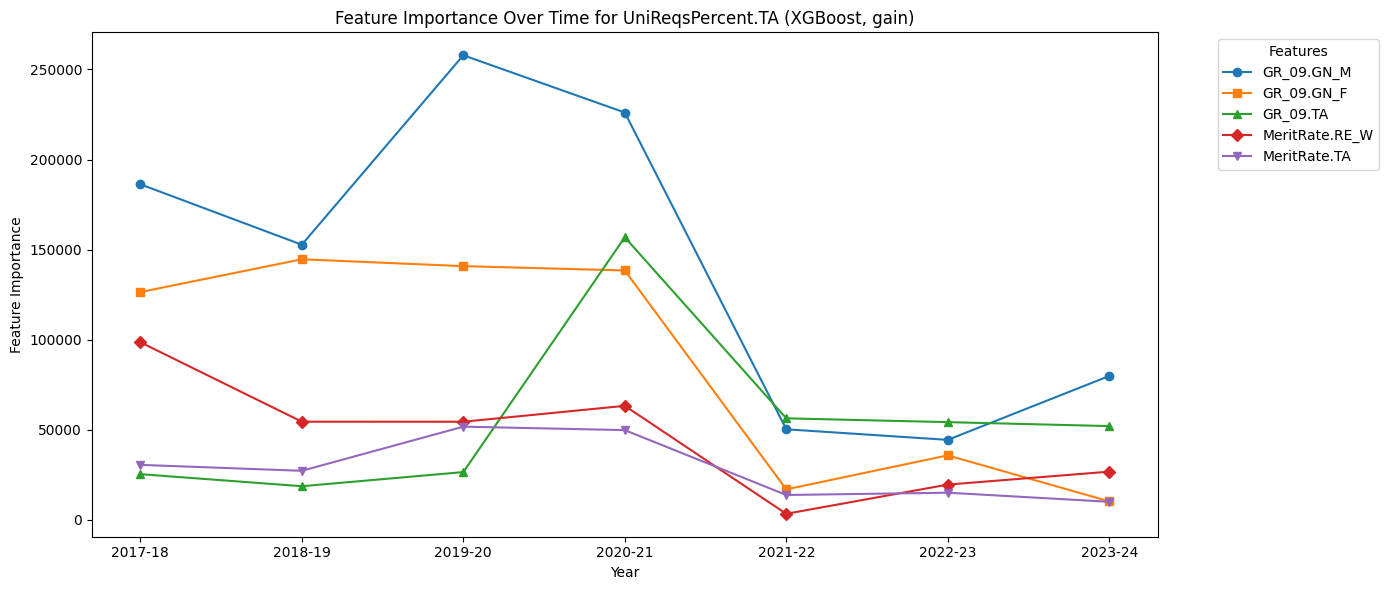

In [29]:
top_features = plot_cv_feature_importance(cv_xgb_models, top_n=5)
plot_top_k_features(cv_xgb_models, "XGBoost", "gain", target_column, k=5)
plot_feature_avg_variance(cv_xgb_models, "XGBoost", "gain", target_column)
plot_feature_time_series(
    cv_xgb_models, "XGBoost", "gain", target_column, top_features[:5]
)

### Non Cross Validated Grad Rate


In [30]:
import modeling.utils.xgboost as xgb

grad_rate = "RegHSDiplomaRate.TA"
xgb_model = "XGBoost"

all_grad_rate_models = {}
for year, df in year_df_mapping.items():
    all_grad_rate_models[year] = xgb.train_xgboost_model(
        df, grad_rate, grad_rate_columns_to_drop, print_plot=False
    )

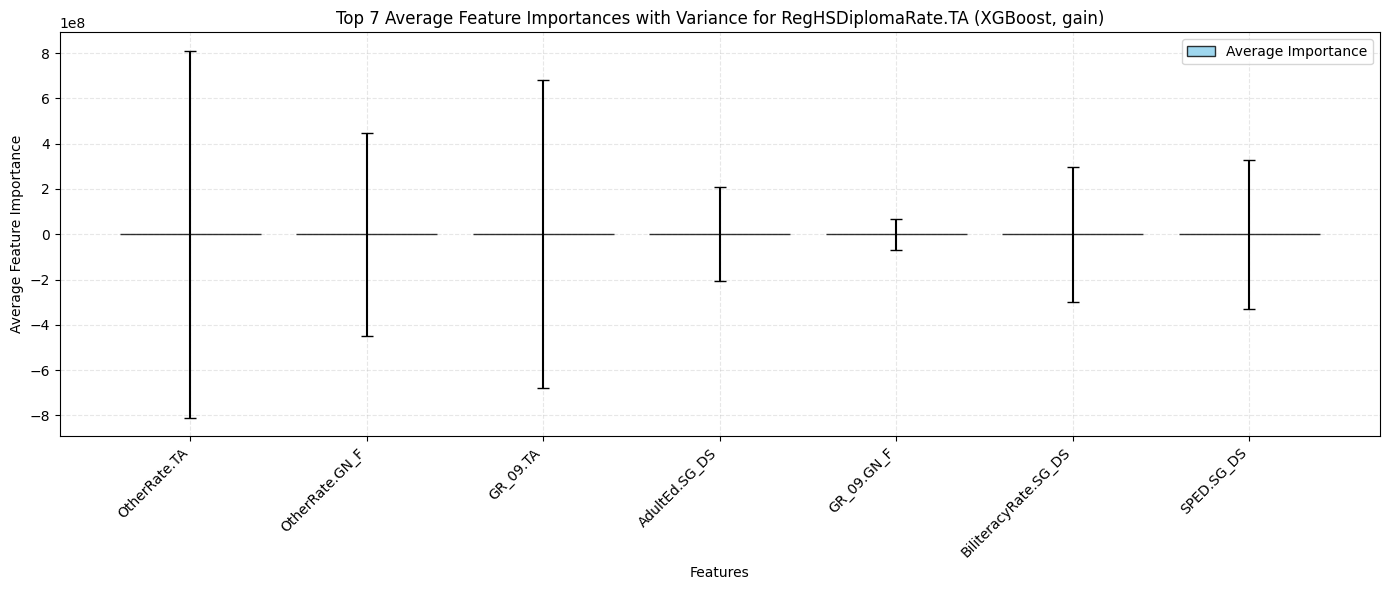

<Figure size 1400x600 with 0 Axes>

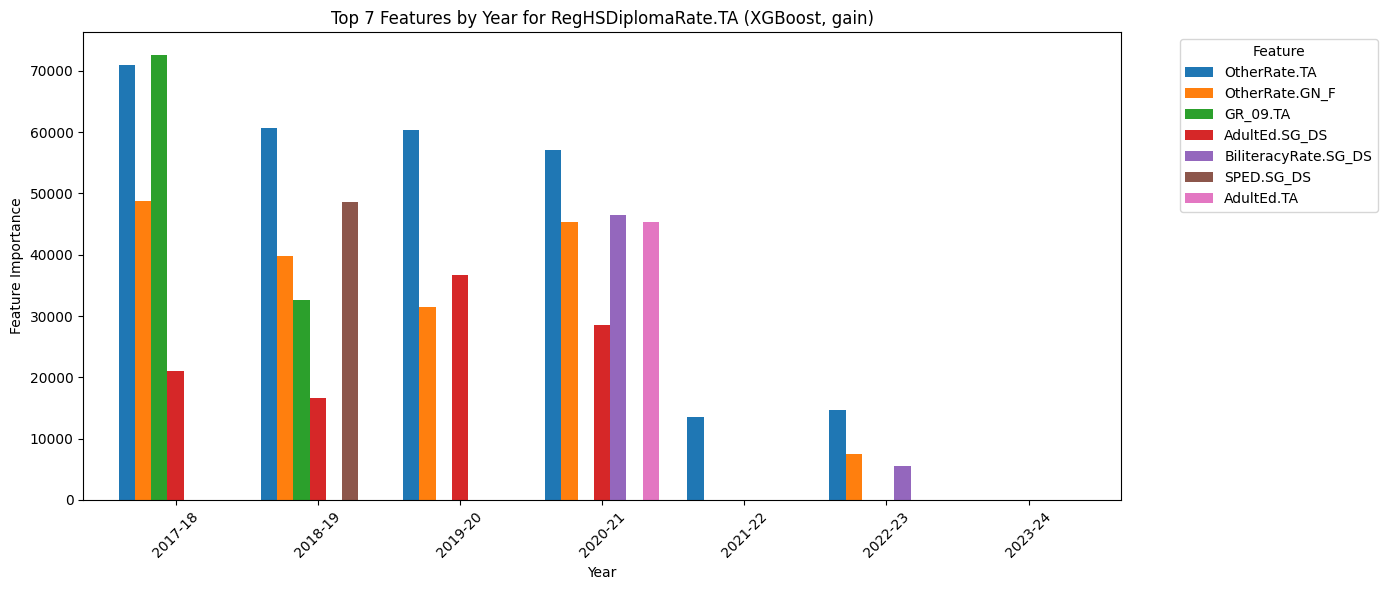

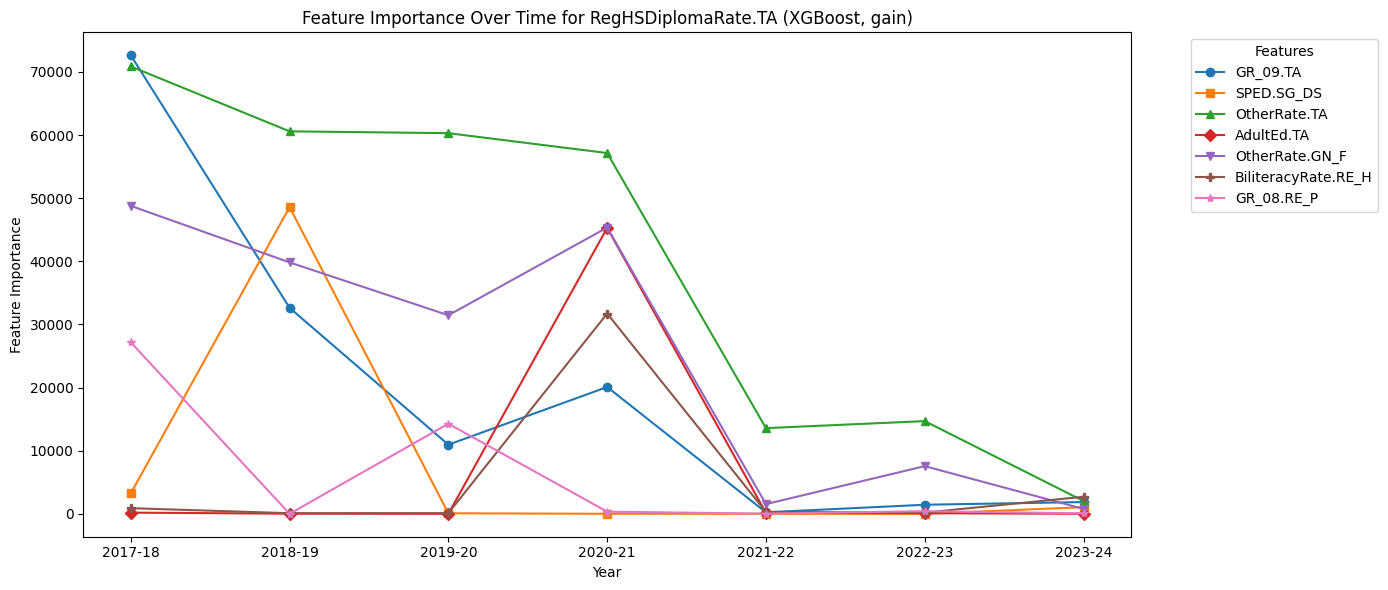

In [31]:
xgb.plot_feature_avg_variance(all_grad_rate_models, xgb_model, "gain", grad_rate, k=7)
top_k_features = xgb.plot_top_k_features(
    all_grad_rate_models, xgb_model, "gain", grad_rate, k=7
)
xgb.plot_feature_time_series(
    all_grad_rate_models, xgb_model, "gain", grad_rate, top_k_features
)

### Non Cross Validated CSU/UC Readiness Rate


In [32]:
uc_csu_rate = "UniReqsPercent.TA"
xgb_model = "XGBoost"

all_csu_rate_models = {}
for year, df in year_df_mapping.items():
    all_csu_rate_models[year] = xgb.train_xgboost_model(
        df, grad_rate, csu_rate_columns_to_drop, print_plot=False
    )

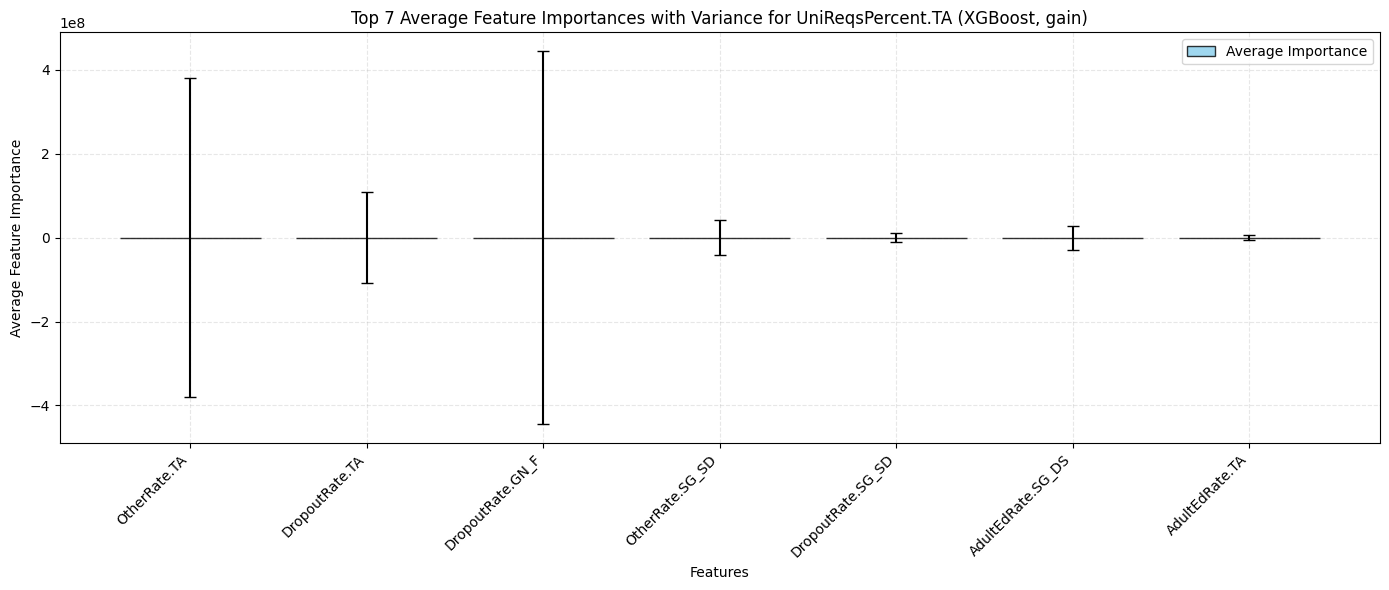

<Figure size 1400x600 with 0 Axes>

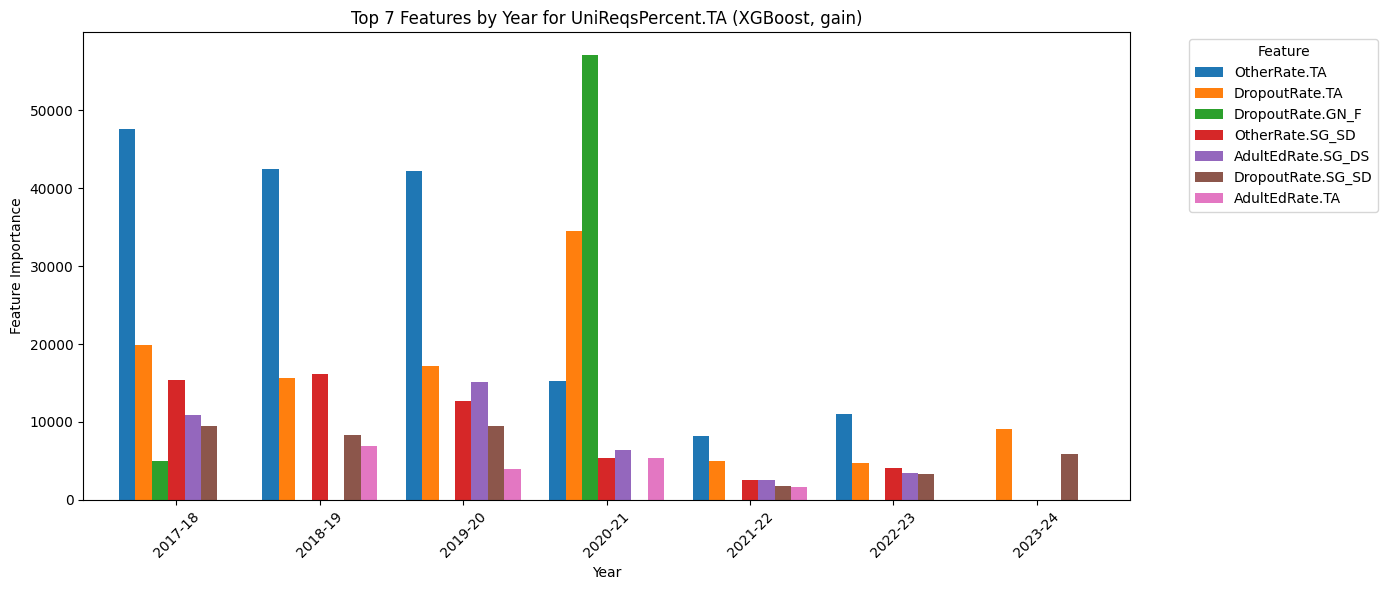

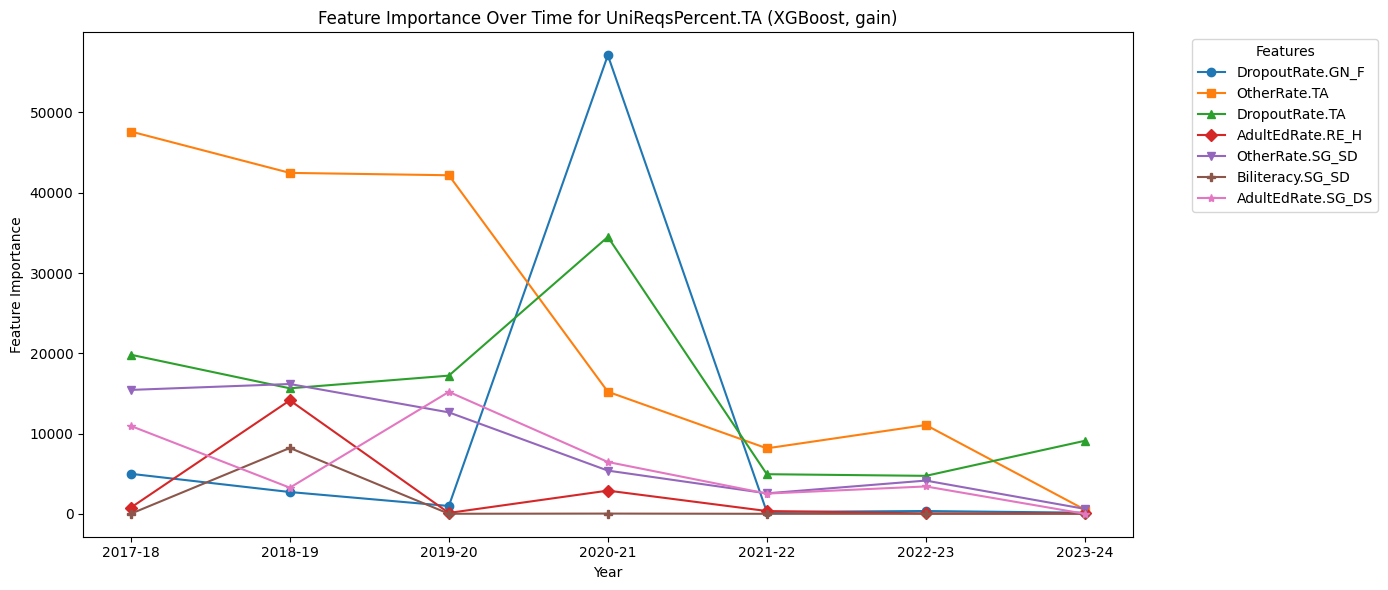

In [33]:
xgb.plot_feature_avg_variance(all_csu_rate_models, xgb_model, "gain", uc_csu_rate, k=7)
top_k_features = xgb.plot_top_k_features(
    all_csu_rate_models, xgb_model, "gain", uc_csu_rate, k=7
)
xgb.plot_feature_time_series(
    all_csu_rate_models, xgb_model, "gain", uc_csu_rate, top_k_features
)

# Random Forest


### Cross Validated Grad Rate


In [34]:
from modeling.utils.randomforest import (
    cross_validate_random_forest,
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
)

cv_models = {}

target_variable = "RegHSDiplomaRate.TA"
years = list(year_df_mapping.keys())

for year in years:
    df = year_df_mapping[year]

    cv_result = cross_validate_random_forest(
        df=df,
        target_column=target_variable,
        columns_to_drop=grad_rate_columns_to_drop,
        n_splits=5,
        print_results=False,
    )

    cv_models[year] = cv_result

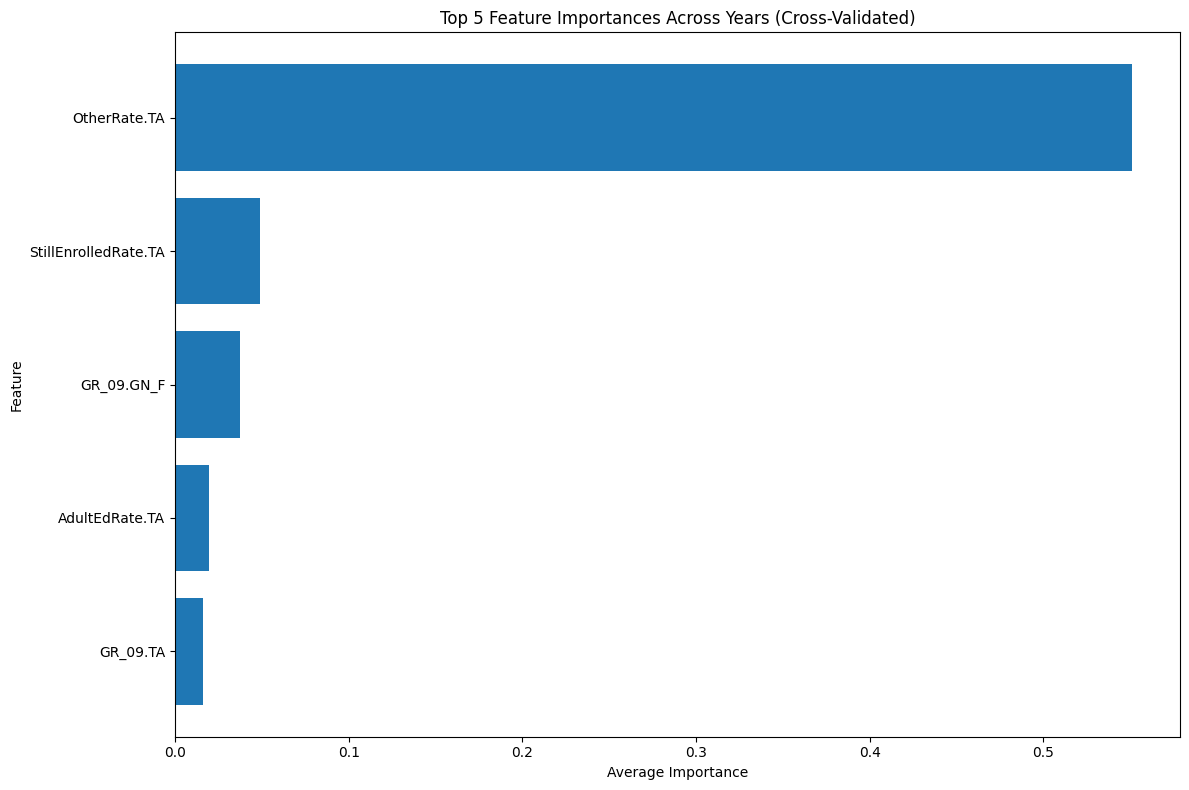

<Figure size 1400x600 with 0 Axes>

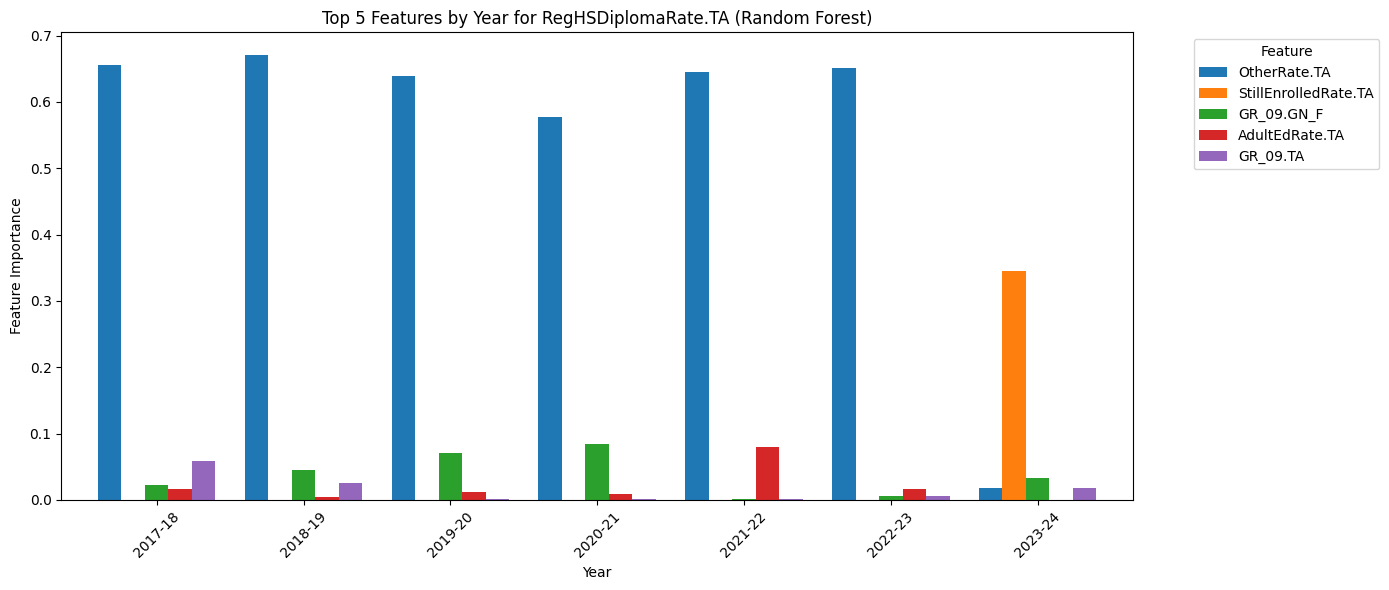

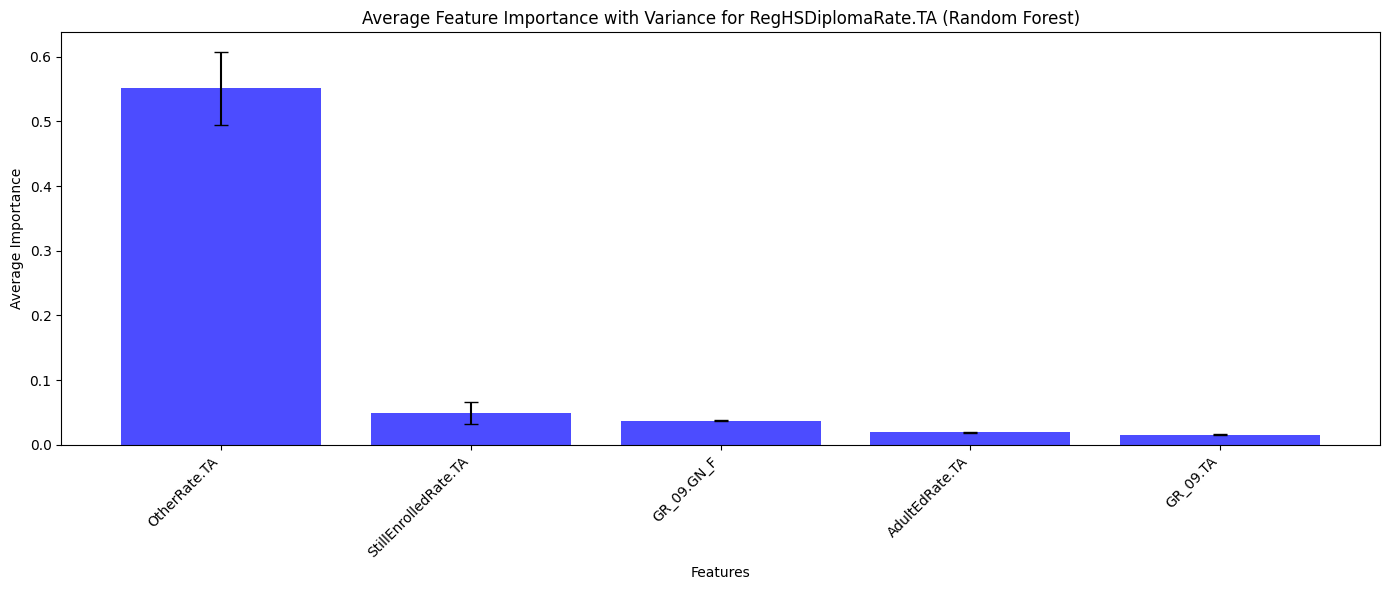

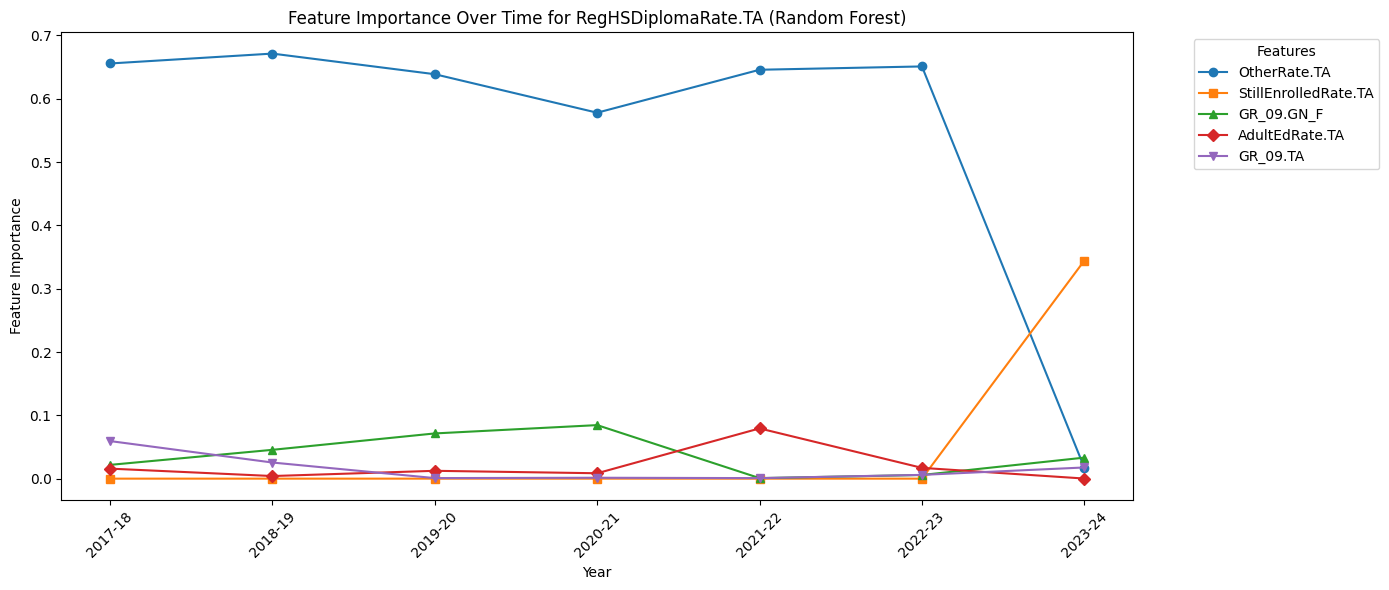

In [35]:
all_top_features = plot_cv_feature_importance_rf(cv_models, top_n=5)

plot_top_k_features_rf(cv_models, target_variable=target_variable, k=5)
plot_feature_avg_variance_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features[:5]
)
plot_feature_time_series_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features[:5]
)

### Cross Validated CSU/UC Readiness Rate


In [36]:
from modeling.utils.randomforest import (
    cross_validate_random_forest,
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
)

cv_models = {}

target_variable = "UniReqsPercent.TA"
years = list(year_df_mapping.keys())

for year in years:
    df = year_df_mapping[year]

    cv_result = cross_validate_random_forest(
        df=df,
        target_column=target_variable,
        columns_to_drop=grad_rate_columns_to_drop,
        n_splits=5,
        print_results=False,
    )

    cv_models[year] = cv_result

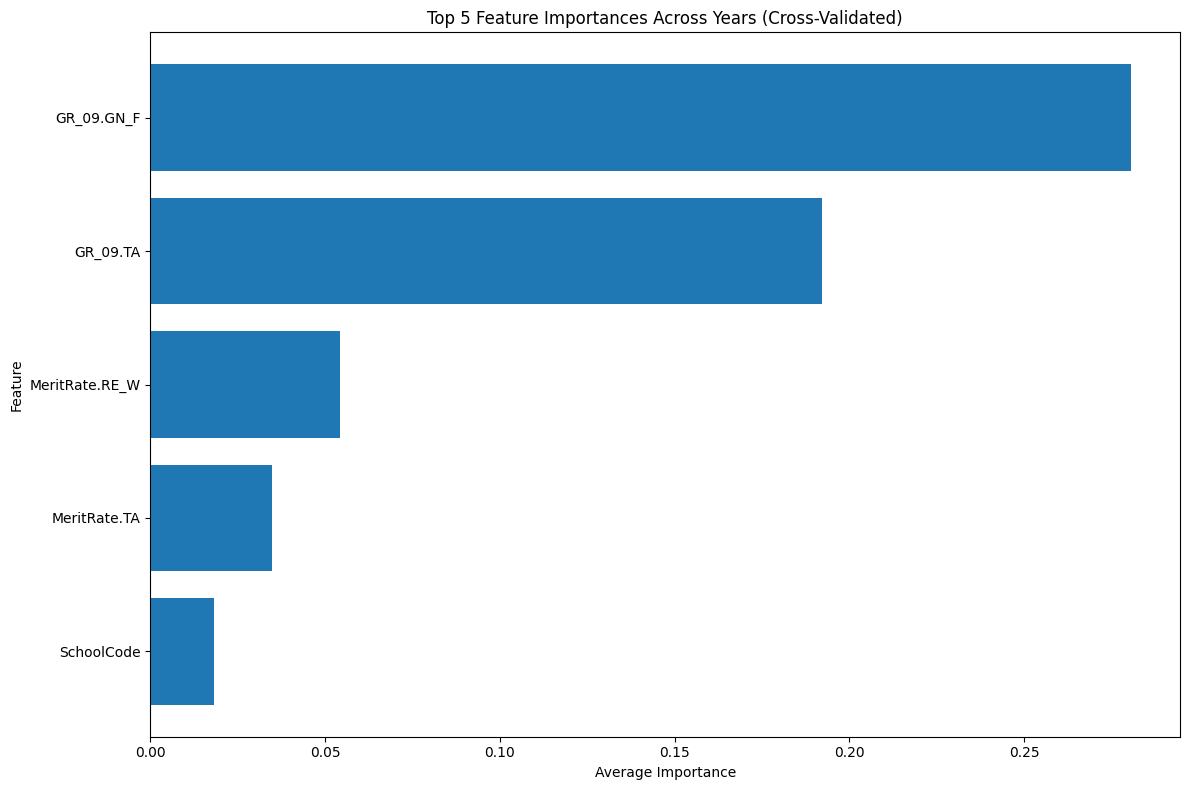

<Figure size 1400x600 with 0 Axes>

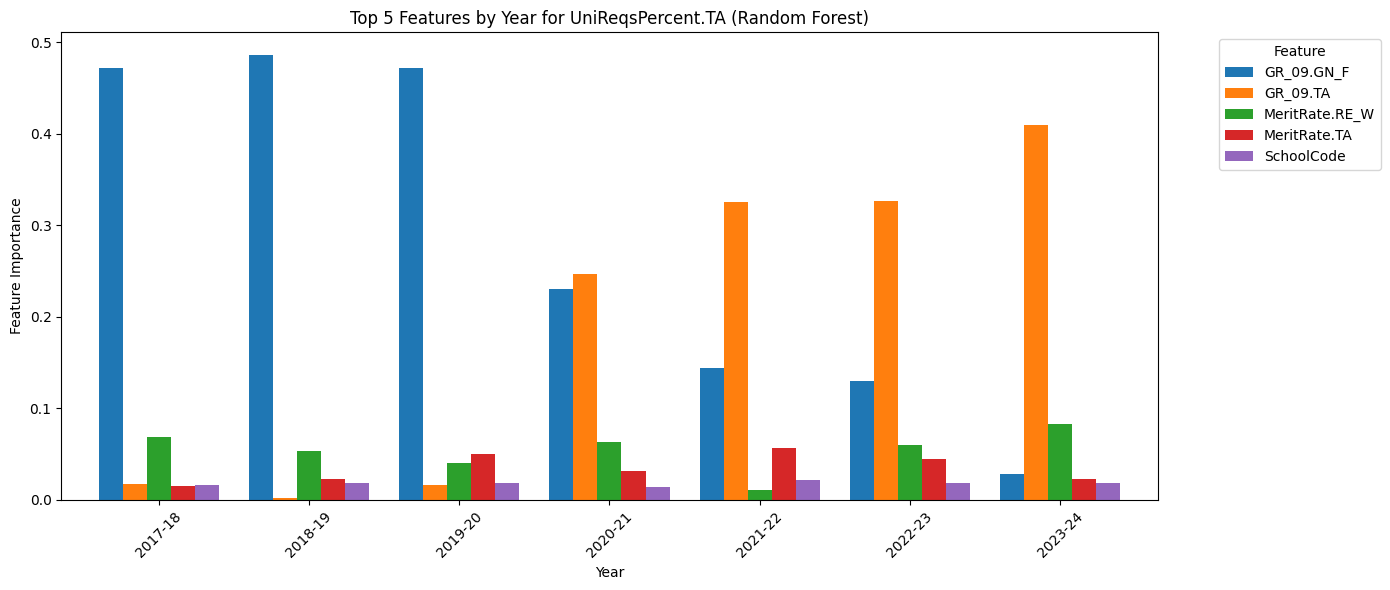

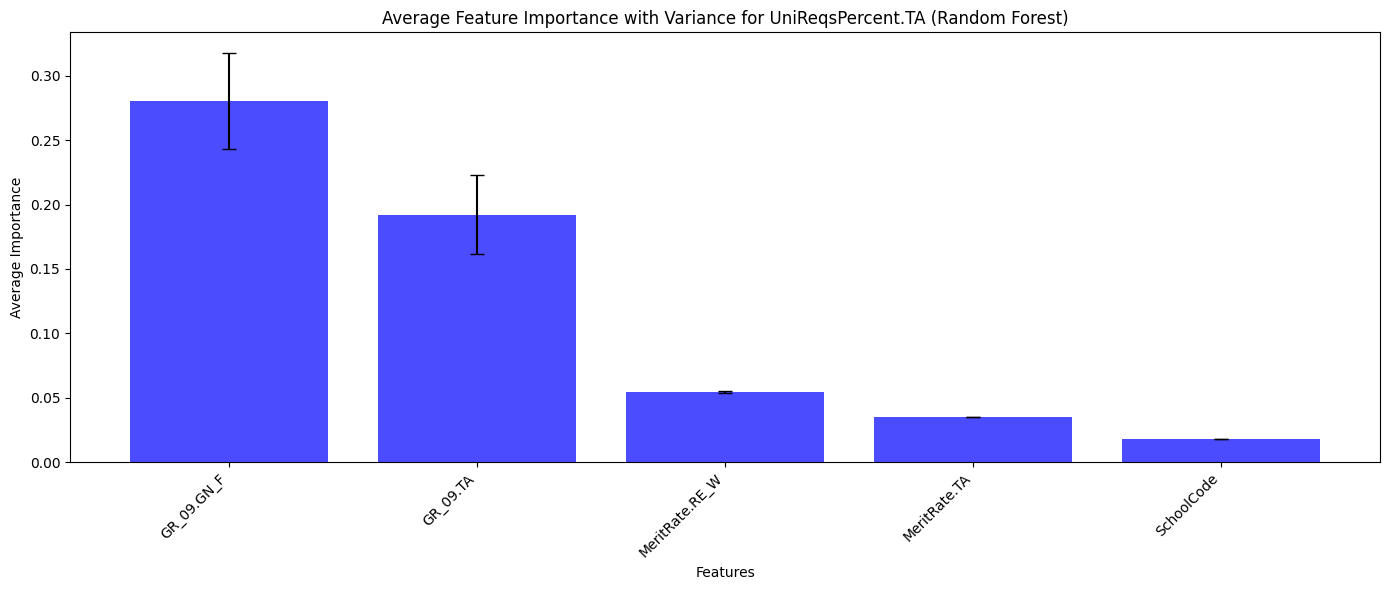

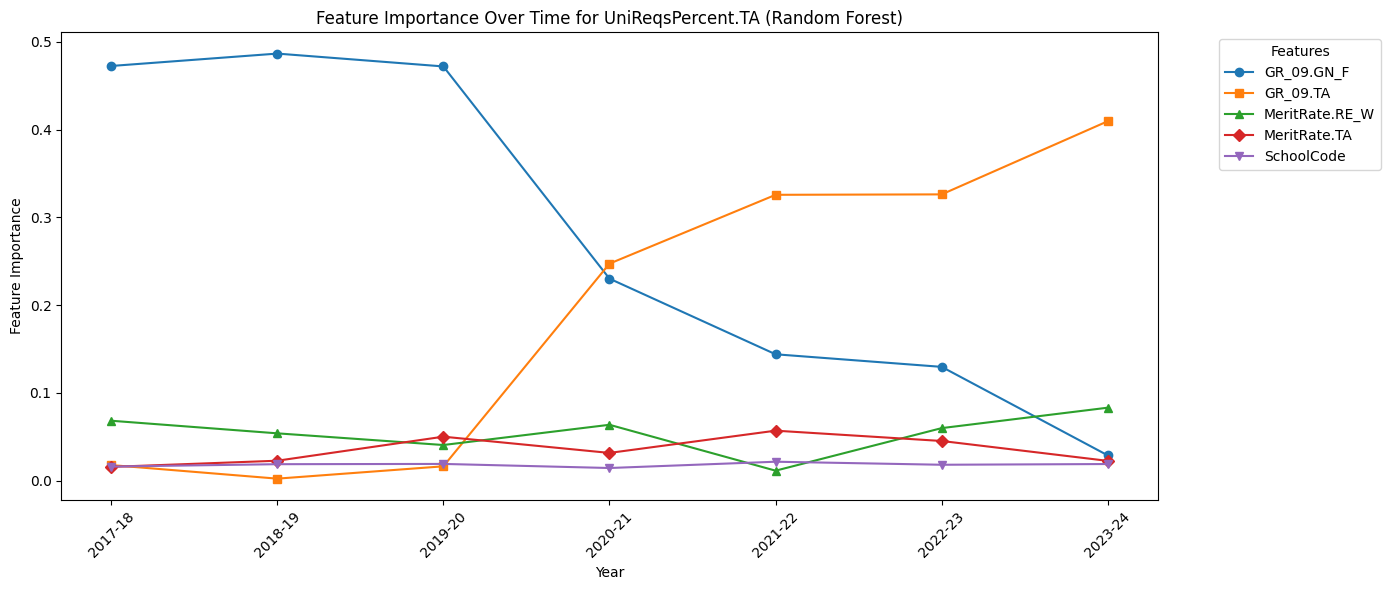

In [37]:
all_top_features = plot_cv_feature_importance_rf(cv_models, top_n=5)

plot_top_k_features_rf(cv_models, target_variable=target_variable, k=5)
plot_feature_avg_variance_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features[:5]
)
plot_feature_time_series_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features[:5]
)

### Non Cross Validated Grad Rate


In [38]:
import modeling.utils.randomforest as rf

grad_rate = "RegHSDiplomaRate.TA"

all_rf_grad_rate_models = {}
for year, df in year_df_mapping.items():
    all_rf_grad_rate_models[year] = rf.train_random_forest_model(
        df, grad_rate, grad_rate_columns_to_drop, print_plot=False
    )

<Figure size 1400x600 with 0 Axes>

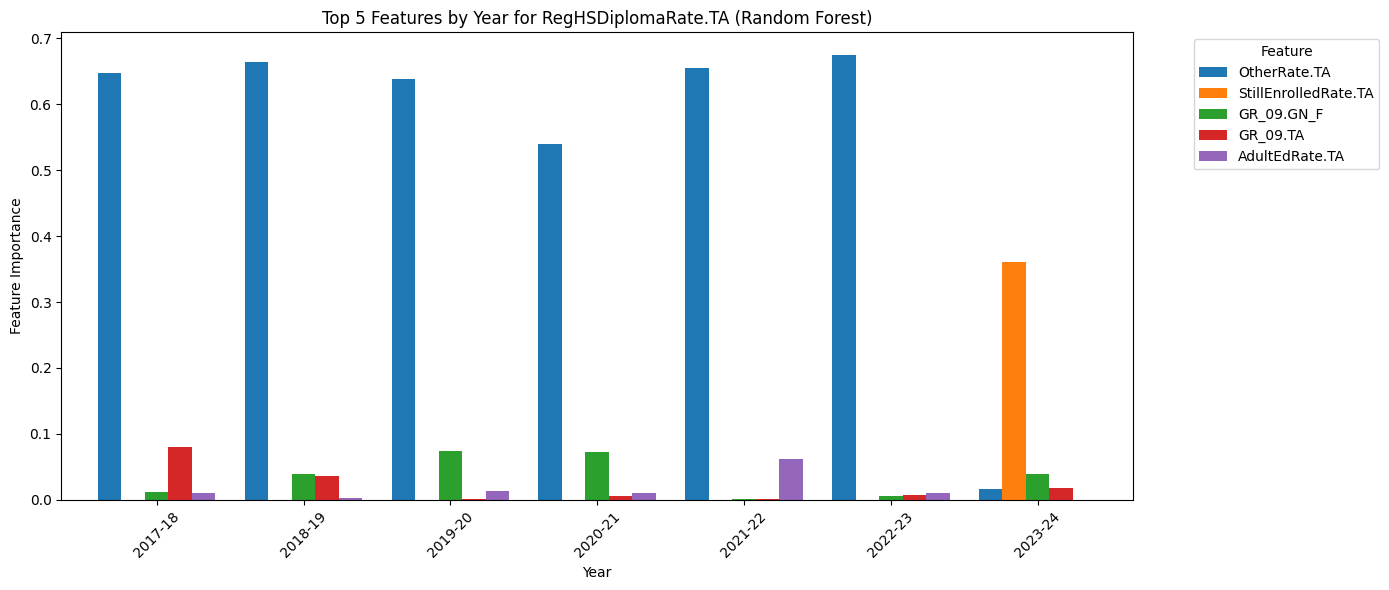

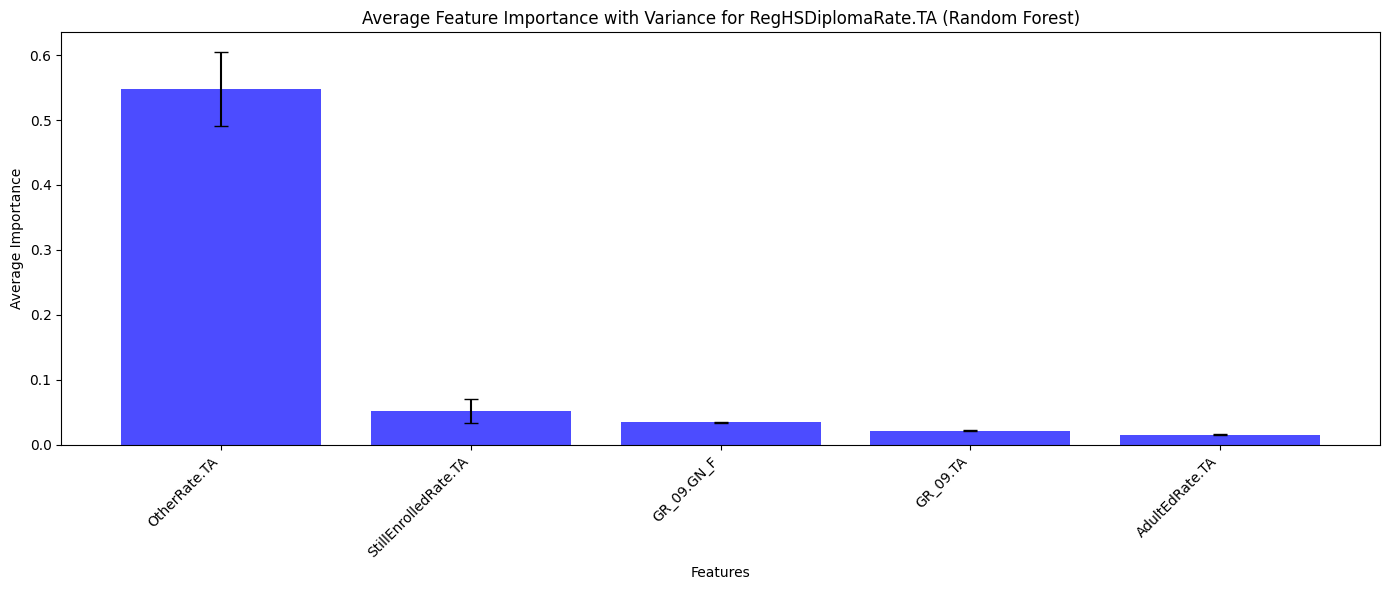

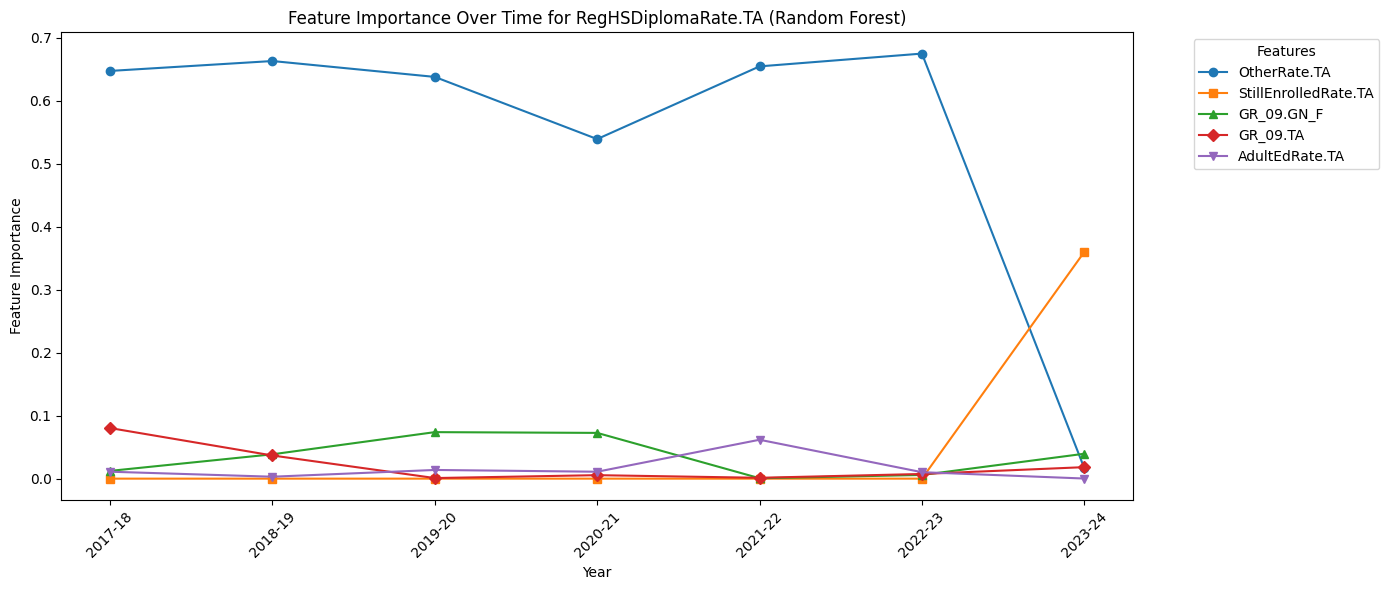

In [39]:
top_k_features_rf = rf.plot_top_k_features_rf(all_rf_grad_rate_models, grad_rate, k=5)

rf.plot_feature_avg_variance_rf(all_rf_grad_rate_models, grad_rate, top_k_features_rf)
rf.plot_feature_time_series_rf(all_rf_grad_rate_models, grad_rate, top_k_features_rf)

### Non Cross Validated CSU/UC Readiness Rate


In [40]:
import modeling.utils.randomforest as rf

csu_uc_rate = "UniReqsPercent.TA"
rf_model = "RandomForest"

all_rf_csu_uc_rate_models = {}
for year, df in year_df_mapping.items():
    all_rf_csu_uc_rate_models[year] = rf.train_random_forest_model(
        df, csu_uc_rate, csu_rate_columns_to_drop, print_plot=False
    )

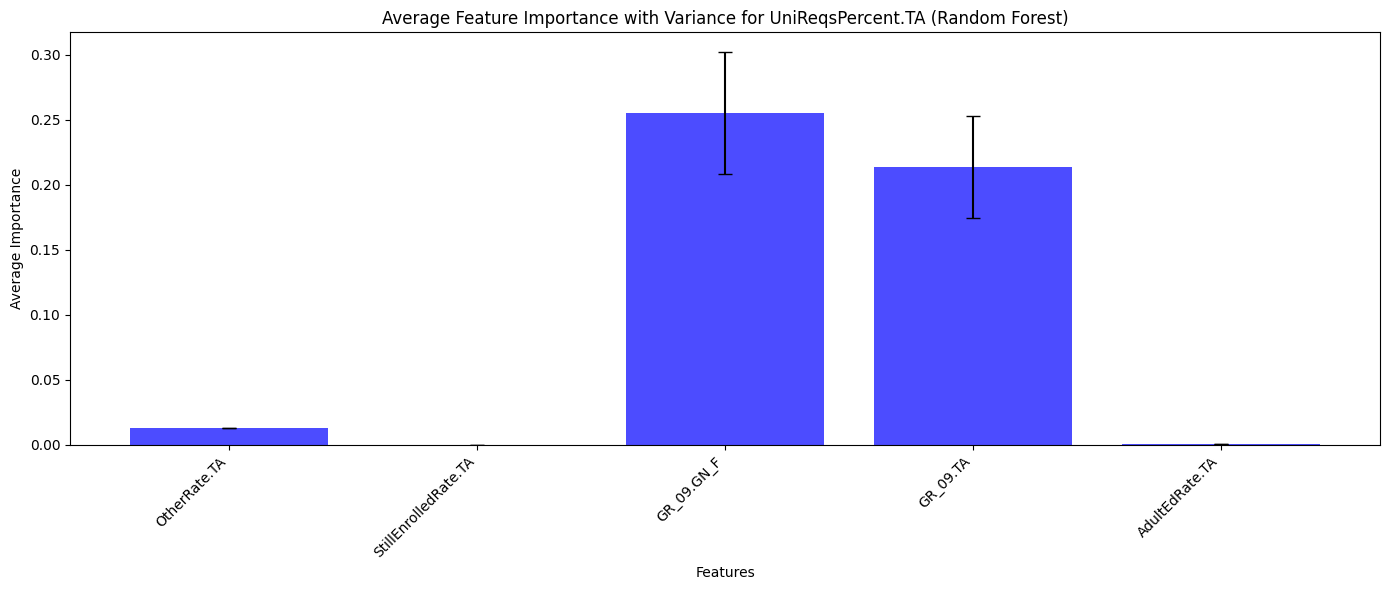

<Figure size 1400x600 with 0 Axes>

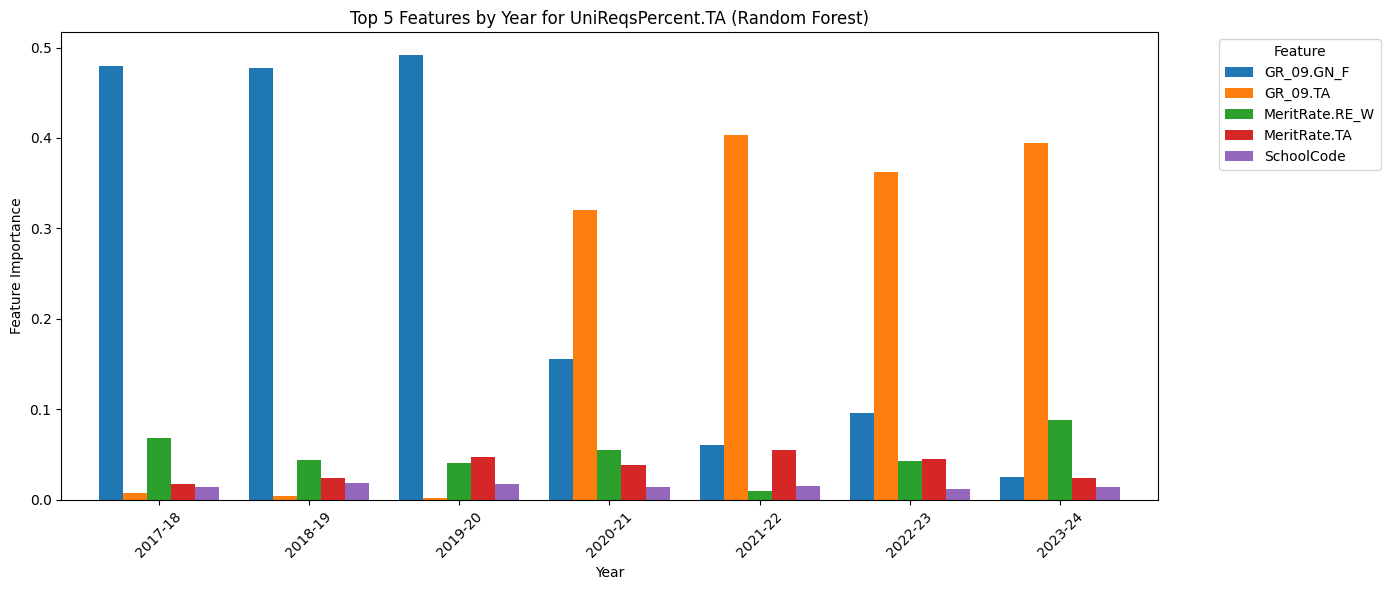

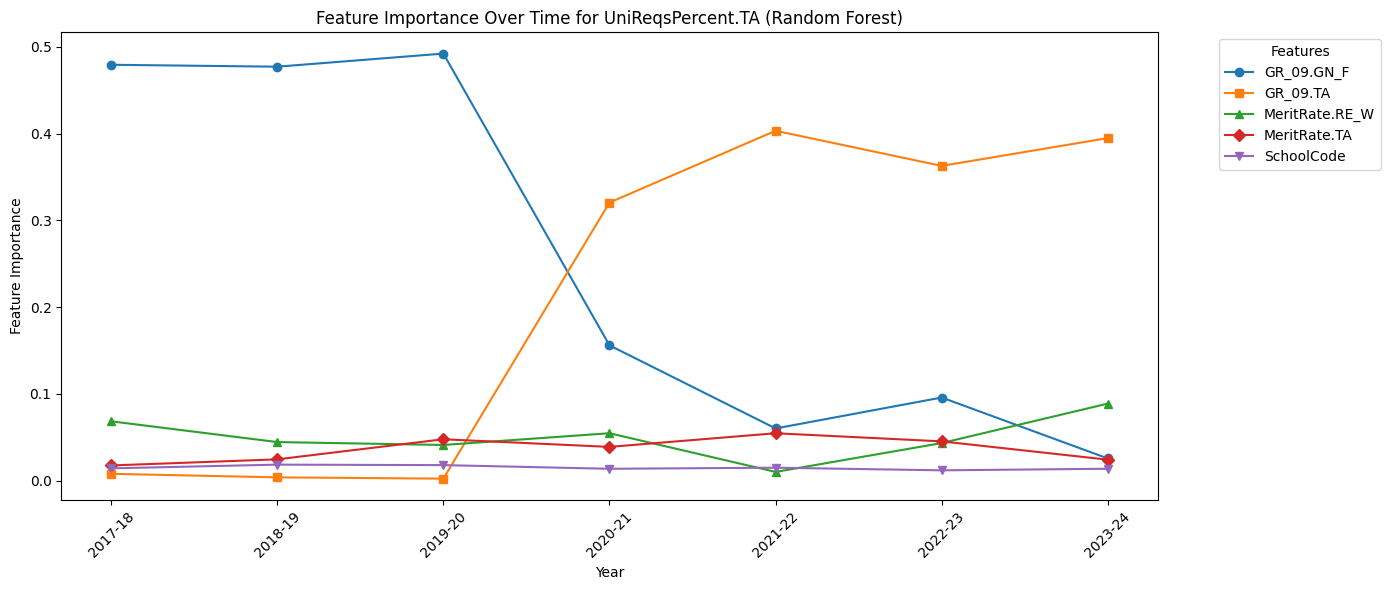

In [41]:
rf.plot_feature_avg_variance_rf(
    all_rf_csu_uc_rate_models, csu_uc_rate, top_k_features_rf
)
top_k_features_rf = rf.plot_top_k_features_rf(
    all_rf_csu_uc_rate_models, csu_uc_rate, k=5
)
rf.plot_feature_time_series_rf(
    all_rf_csu_uc_rate_models, csu_uc_rate, top_k_features_rf
)

In [42]:
con.close()